## REINFORCE: REINFORCE with Entropy Regularization

动作的熵加入loss，使其尽可能大，以便让模型更为健壮

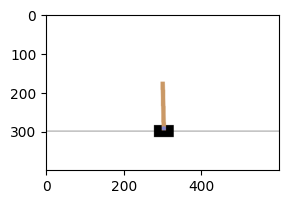

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    over = terminated or truncated

    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
        over = True
    
    #没坚持到最后,扣分
    if over and self.step_n < 200:
        reward = -1000

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch
	
#定义模型,评估状态下每个动作的价值
model = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
	torch.nn.Softmax(dim=1),
)

model

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Softmax(dim=1)
)

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
	state = []
	action = []
	reward = []

	s = env.reset()
	o = False
	while not o:
		# 根据环境采样
		prob = model(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
		a = random.choices(range(2), weights=prob, k=1)[0]
		
		ns, r, o = env.step(a)

		state.append(s)
		action.append(a)
		reward.append(r)
  
		s = ns

		if show:
			display.clear_output(wait=True)
			env.show()
  
	state = torch.FloatTensor(state).reshape(-1, 4)
	action = torch.LongTensor(action).reshape(-1, 1)
	reward = torch.FloatTensor(reward).reshape(-1, 1)

	return state, action, reward, reward.sum().item()

state, action, reward, reward_sum = play()

reward_sum

-967.0

In [9]:
#训练
def train():
	model.train()
	# model_delay.eval()  # code changed here
	optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
	# loss_fn = torch.nn.MSELoss()

	#共更新N轮数据
	for epoch in range(1000):
		# 一个epoch玩N步
		steps = 0
		while steps < 200:
			# 玩一局，得到数据
			state, action, reward, _ = play()
			steps += len(state)

			#计算当前state的价值，即Q(state, action), 用MC估计
			value = []
			for i in range(len(reward)):
				s = 0
				for j in range(i, len(reward)):
					s += reward[j] * 0.99**(j - i)
				value.append(s)
			value = torch.FloatTensor(value).reshape(-1, 1)

			# 重新计算动作的概率
			prob = model(state).gather(dim=1, index=action)
  
			# 求Q最大的导函数 -> partial value / partial action
			loss = (prob + 1e-8).log() * value
			for i in range(len(loss)):
				loss[i] = loss[i] * 0.99 ** i
			loss = -loss.mean()

			"""code changed here"""
			# 计算动作熵，越大越好
			entropy = prob * (prob + 1e-8).log()
			entropy = -entropy.mean()
			loss -= entropy * 5

			loss.backward()
			optimizer.step()
			optimizer.zero_grad()


		if epoch % 100 == 0:
			test_result = sum([play()[-1] for _ in range(20)]) / 20
			print(epoch, loss.item(), entropy.item(), test_result)

train()

0 14.090710639953613 0.23373658955097198 37.4
100 14.911650657653809 0.24650397896766663 -111.0
200 13.65561580657959 0.2569299042224884 -210.55
300 13.491044998168945 0.24247951805591583 -262.55
400 14.033771514892578 0.24421298503875732 -2.3
500 16.352195739746094 0.2279282808303833 200.0
600 13.488458633422852 0.24378618597984314 89.95
700 14.661059379577637 0.24683243036270142 200.0
800 12.779264450073242 0.21243828535079956 148.45
900 14.107919692993164 0.22734564542770386 200.0


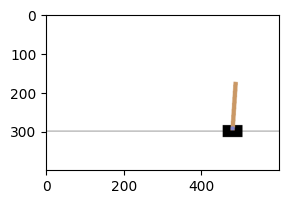

200.0

In [10]:
play(True)[-1]